## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [4]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 682.7 kB/s eta 0:02:29
   ---------------------------------------- 0.1/101.1 MB 787.7 kB/s eta 0:02:09
   ---------------------------------------- 0.1/101.1 MB 1.1 MB/s eta 0:01:30
   ---------------------------------------- 0.3/101.1 MB 2.0 MB/s eta 0:00:52
   ---------------------------------------- 0.6/101.1 MB 2.6 MB/s eta 0:00:40
   ---------------------------------------- 1.1/101.1 MB 4.4 MB/s eta 0:00:23
    --------------------------------------- 2.2/101.1 MB 6.9 MB/s eta 0:00:15
   - -------------------------------------- 3.1/101.1 MB 8.6 MB/s eta 0:00:12
   - -------------------------------------- 4.0/101.1 MB 10.3 MB/s eta 0:00:10
   - -------------------------------------- 4.2/101.1 MB 9.5 MB/s eta 0:00:11
 

In [6]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-2.0.3-py3-none-win_amd64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-win_amd64.whl (99.8 MB)


In [7]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [9]:
df = pd.read_csv('data/students.csv')

#### Show Top 5 Records

In [10]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Preparing X and Y variables

In [11]:
X = df.drop(columns=['math score'],axis=1)

In [12]:
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [13]:
def print_unique_categories(df, column_name):
    print(f"Categories in '{column_name}' variable:", end=" ")
    print(df[column_name].unique())

# Usage of the function to print unique categories
print_unique_categories(df, 'gender')
print_unique_categories(df, 'race/ethnicity')
print_unique_categories(df, 'parental level of education')
print_unique_categories(df, 'lunch')
print_unique_categories(df, 'test preparation course')

Categories in 'gender' variable: ['female' 'male']
Categories in 'race/ethnicity' variable: ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in 'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable: ['standard' 'free/reduced']
Categories in 'test preparation course' variable: ['none' 'completed']


In [14]:
y = df['math score']

In [15]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

In [16]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [17]:
X = preprocessor.fit_transform(X)

In [18]:
X.shape

(1000, 19)

In [19]:
X

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [20]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=20240603)
X_train.shape, X_test.shape

((800, 19), (200, 19))

#### Create an Evaluate Function to give all metrics after model Training

In [21]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [25]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}


model_list = []
mae_list = []
rmse_list = []
r2_list = []

for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(model_name)
    model_list.append(model_name)
    mae_list.append(model_test_mae)
    rmse_list.append(model_test_rmse)
    r2_list.append(model_test_r2)
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.2752
- Mean Absolute Error: 4.2218
- R2 Score: 0.8750
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.5678
- Mean Absolute Error: 4.3679
- R2 Score: 0.8793


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.4961
- Mean Absolute Error: 5.1323
- R2 Score: 0.8105
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 7.1658
- Mean Absolute Error: 5.6649
- R2 Score: 0.8001


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.2755
- Mean Absolute Error: 4.2203
- R2 Score: 0.8750
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.5710
- Mean Absolute Error: 4.3692
- R2 Score: 0.8792


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7806
- Mean Absolute Error: 4.6005
- R2 Score: 0.8500
-----------------------

### Results

In [26]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,0.879316
2,Ridge,0.879180
7,CatBoosting Regressor,0.860821
5,Random Forest Regressor,0.837800
8,AdaBoost Regressor,0.830886
6,XGBRegressor,0.819212
1,Lasso,0.800105
3,K-Neighbors Regressor,0.777225
4,Decision Tree,0.706902


In [27]:
# Create the result dataframe
result = pd.DataFrame({
    'Model Name': model_list,
    'MAE': mae_list,
    'RMSE': rmse_list,
    'R2_Score': r2_list
})

# Sort the result based on the desired metric
result_sorted = result.sort_values(by="R2_Score", ascending=False)  # Sorting by R2_Score, change as needed
print(result_sorted)

                Model Name       MAE      RMSE  R2_Score
0        Linear Regression  4.367869  5.567849  0.879316
2                    Ridge  4.369179  5.570977  0.879180
7    CatBoosting Regressor  4.636076  5.979293  0.860821
5  Random Forest Regressor  5.064412  6.454878  0.837800
8       AdaBoost Regressor  4.980010  6.591018  0.830886
6             XGBRegressor  5.377417  6.814713  0.819212
1                    Lasso  5.664883  7.165784  0.800105
3    K-Neighbors Regressor  5.785000  7.564774  0.777225
4            Decision Tree  6.900000  8.676981  0.706902


### Best Machine Learning Model Analysis

Based on the evaluation metrics, the **Linear Regression** model emerges as the best performing model for this project. Here are the reasons and a comparison with other models to substantiate this conclusion:

#### Performance Metrics:
- **Linear Regression**:
  - **MAE**: 4.367869
  - **RMSE**: 5.567849
  - **R2 Score**: 0.879316

#### Why Linear Regression is the Best:
1. **Highest R2 Score**: Linear Regression has the highest R2 Score (0.879316), indicating that it explains the highest proportion of the variance in the dependent variable among all the models.
2. **Low Error Metrics**: The model has one of the lowest Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) values, meaning its predictions are closer to the actual values on average.

#### Comparison with Other Models:
- **Ridge Regression**:
  - **MAE**: 4.369179
  - **RMSE**: 5.579077
  - **R2 Score**: 0.879180
  - **Comparison**: Ridge Regression is very close in performance to Linear Regression, with slightly higher error metrics and a marginally lower R2 Score.

- **CatBoosting Regressor**:
  - **MAE**: 4.636076
  - **RMSE**: 5.979293
  - **R2 Score**: 0.860821
  - **Comparison**: CatBoosting Regressor also performs well but has higher error metrics and a lower R2 Score compared to Linear Regression.

- **Random Forest Regressor**:
  - **MAE**: 5.064412
  - **RMSE**: 6.454878
  - **R2 Score**: 0.837800
  - **Comparison**: This model shows higher error metrics and a lower R2 Score, indicating less accuracy compared to Linear Regression.

- **AdaBoost Regressor**:
  - **MAE**: 4.980010
  - **RMSE**: 6.591018
  - **R2 Score**: 0.830886
  - **Comparison**: While it performs reasonably well, it still lags behind Linear Regression in terms of all evaluation metrics.

- **XGBRegressor**:
  - **MAE**: 5.377417
  - **RMSE**: 6.814713
  - **R2 Score**: 0.819212
  - **Comparison**: This model has higher error metrics and a lower R2 Score compared to Linear Regression, making it less accurate.

- **Lasso**:
  - **MAE**: 5.664883
  - **RMSE**: 7.165784
  - **R2 Score**: 0.800165
  - **Comparison**: Lasso Regression has significantly higher error metrics and a lower R2 Score, making it less favorable.

- **K-Neighbors Regressor**:
  - **MAE**: 5.785000
  - **RMSE**: 7.564774
  - **R2 Score**: 0.777225
  - **Comparison**: This model performs poorly in comparison, with much higher error metrics and a lower R2 Score.

- **Decision Tree**:
  - **MAE**: 6.900000
  - **RMSE**: 8.676981
  - **R2 Score**: 0.706902
  - **Comparison**: Decision Tree shows the poorest performance with the highest error metrics and the lowest R2 Score among all the models.

### Conclusion
The **Linear Regression** model is the best choice for this project due to its highest R2 Score and relatively low error metrics. While Ridge Regression and CatBoosting Regressor also perform well, Linear Regression's balance of accuracy and simplicity makes it the most suitable model for predicting student performance in this context.


## Linear Regression

In [28]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 87.93


## Plot y_pred and y_test

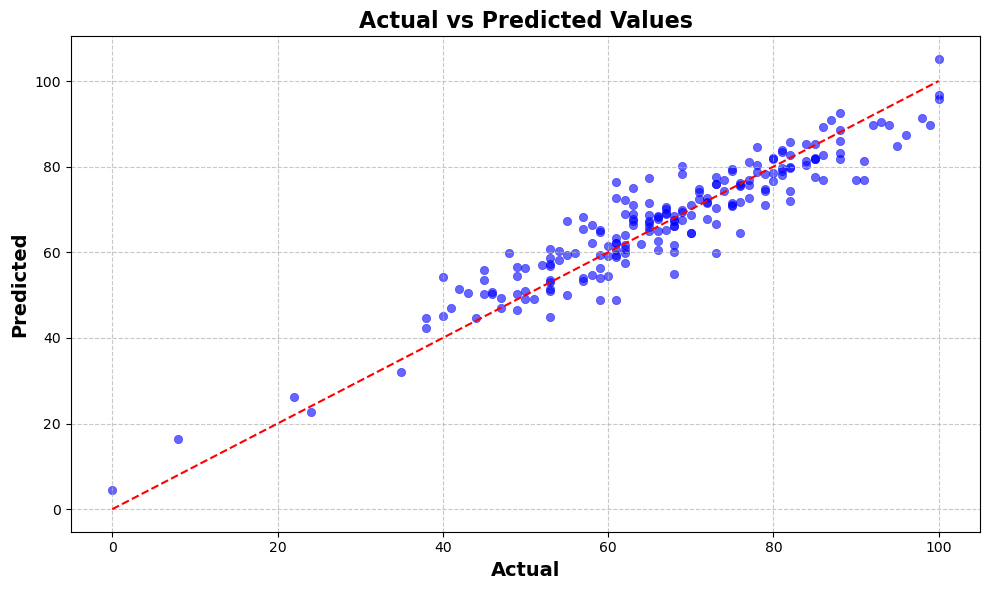

In [30]:
# Scatter plot with enhancements
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6, edgecolor=None)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Regression line
plt.xlabel('Actual', fontsize=14, fontweight='bold')
plt.ylabel('Predicted', fontsize=14, fontweight='bold')
plt.title('Actual vs Predicted Values', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

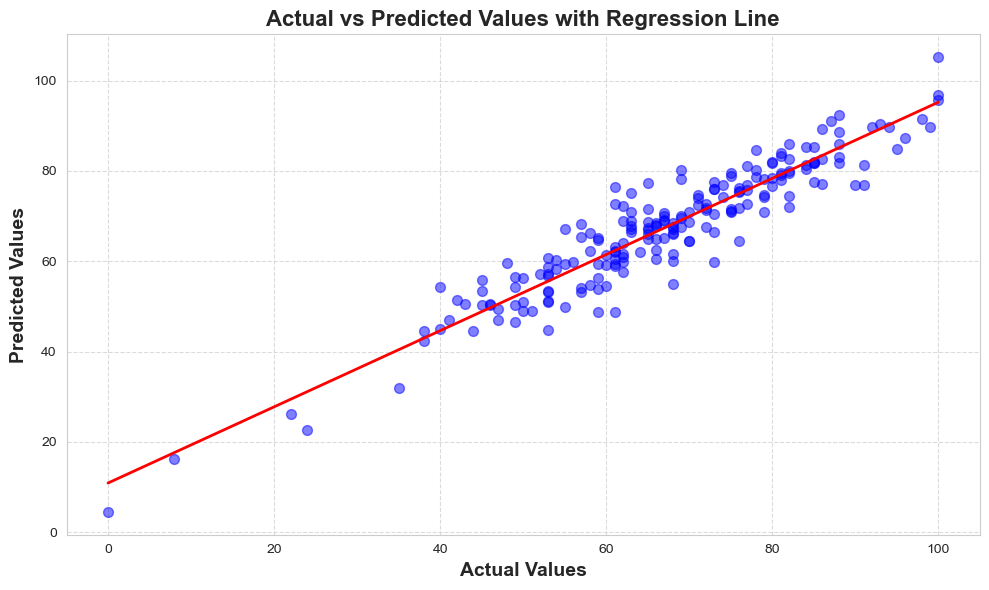

In [31]:
# Setting the style and size of the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Regression plot with enhancements
sns.regplot(x=y_test, y=y_pred, ci=None, color='blue', scatter_kws={'s':50, 'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})

# Adding titles and labels
plt.xlabel('Actual Values', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Values', fontsize=14, fontweight='bold')
plt.title('Actual vs Predicted Values with Regression Line', fontsize=16, fontweight='bold')

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()

#### Difference between Actual and Predicted Values

In [39]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
415,84,81.329692,2.670308
482,68,66.163641,1.836359
379,66,68.421817,-2.421817
987,81,83.309957,-2.309957
359,80,81.784438,-1.784438
...,...,...,...
962,100,96.726971,3.273029
27,67,65.233195,1.766805
7,40,45.054055,-5.054055
495,68,68.517759,-0.517759


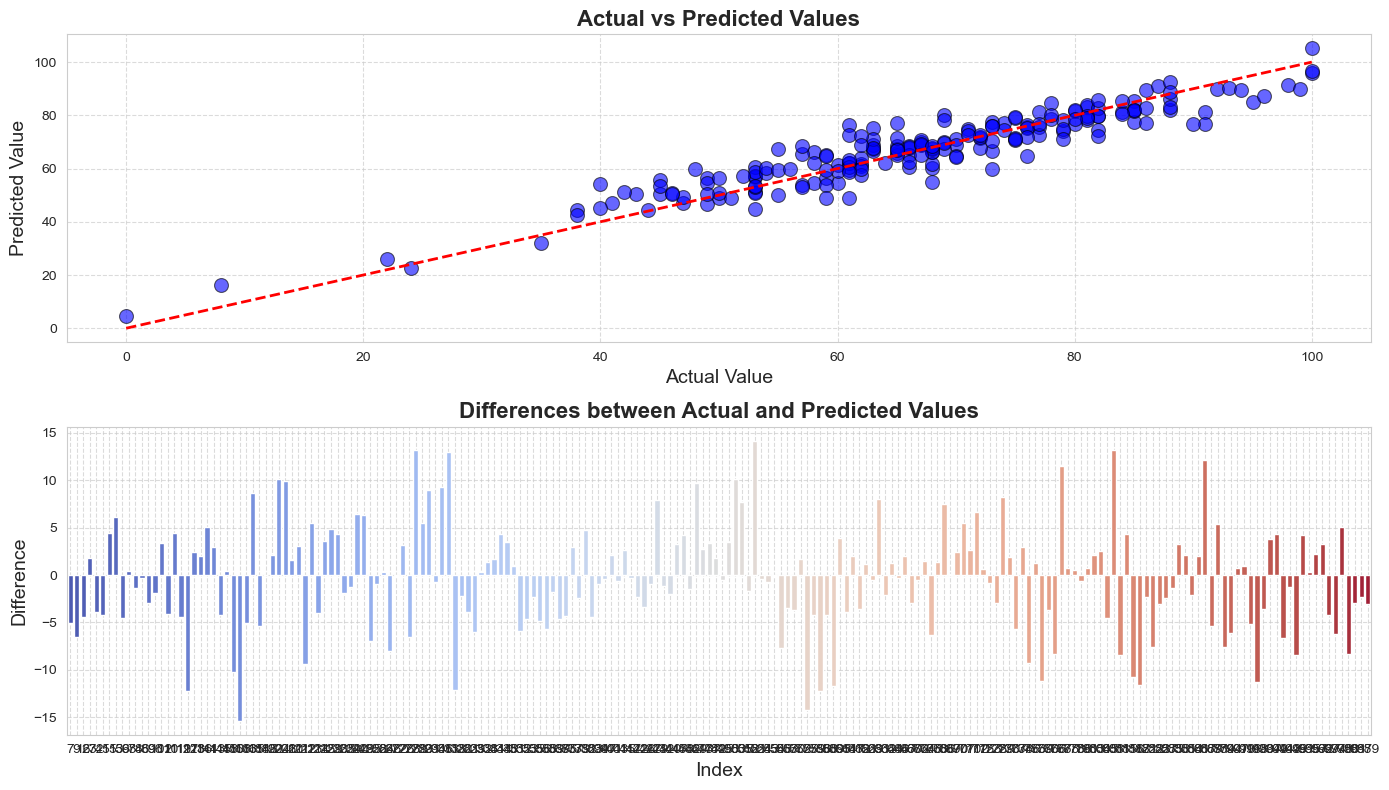

In [40]:
# Ensure y_test and y_pred are in the same format
y_test = y_test.flatten() if len(y_test.shape) > 1 else y_test
y_pred = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred

# Create the DataFrame
pred_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred,
    'Difference': y_test - y_pred
})

# Plotting the Actual vs Predicted Values with their Differences
plt.figure(figsize=(14, 8))

# Scatter plot for actual vs predicted values
plt.subplot(2, 1, 1)
sns.scatterplot(x='Actual Value', y='Predicted Value', data=pred_df, color='blue', s=100, alpha=0.6, edgecolor='k')
plt.plot([pred_df['Actual Value'].min(), pred_df['Actual Value'].max()],
         [pred_df['Actual Value'].min(), pred_df['Actual Value'].max()],
         color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values', fontsize=16, fontweight='bold')
plt.xlabel('Actual Value', fontsize=14)
plt.ylabel('Predicted Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Bar plot for differences
plt.subplot(2, 1, 2)
sns.barplot(x=pred_df.index, y='Difference', data=pred_df, palette='coolwarm')
plt.title('Differences between Actual and Predicted Values', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Difference', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

In [41]:
# Create the DataFrame
pred_df_new = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred,
    'Difference': y_test - y_pred
})

# Format the DataFrame to show values with consistent decimal places
pred_df_new = pred_df.round(2)

# Sort the DataFrame by Actual Value for better readability
pred_df_new = pred_df.sort_values(by='Actual Value').reset_index(drop=True)

# Display the DataFrame
print(pred_df_new)


     Actual Value  Predicted Value  Difference
0               0         4.495907   -4.495907
1               8        16.335766   -8.335766
2              22        26.185306   -4.185306
3              24        22.665784    1.334216
4              35        31.946086    3.053914
..            ...              ...         ...
195            98        91.399714    6.600286
196            99        89.726021    9.273979
197           100        96.726971    3.273029
198           100       105.174373   -5.174373
199           100        95.793365    4.206635

[200 rows x 3 columns]


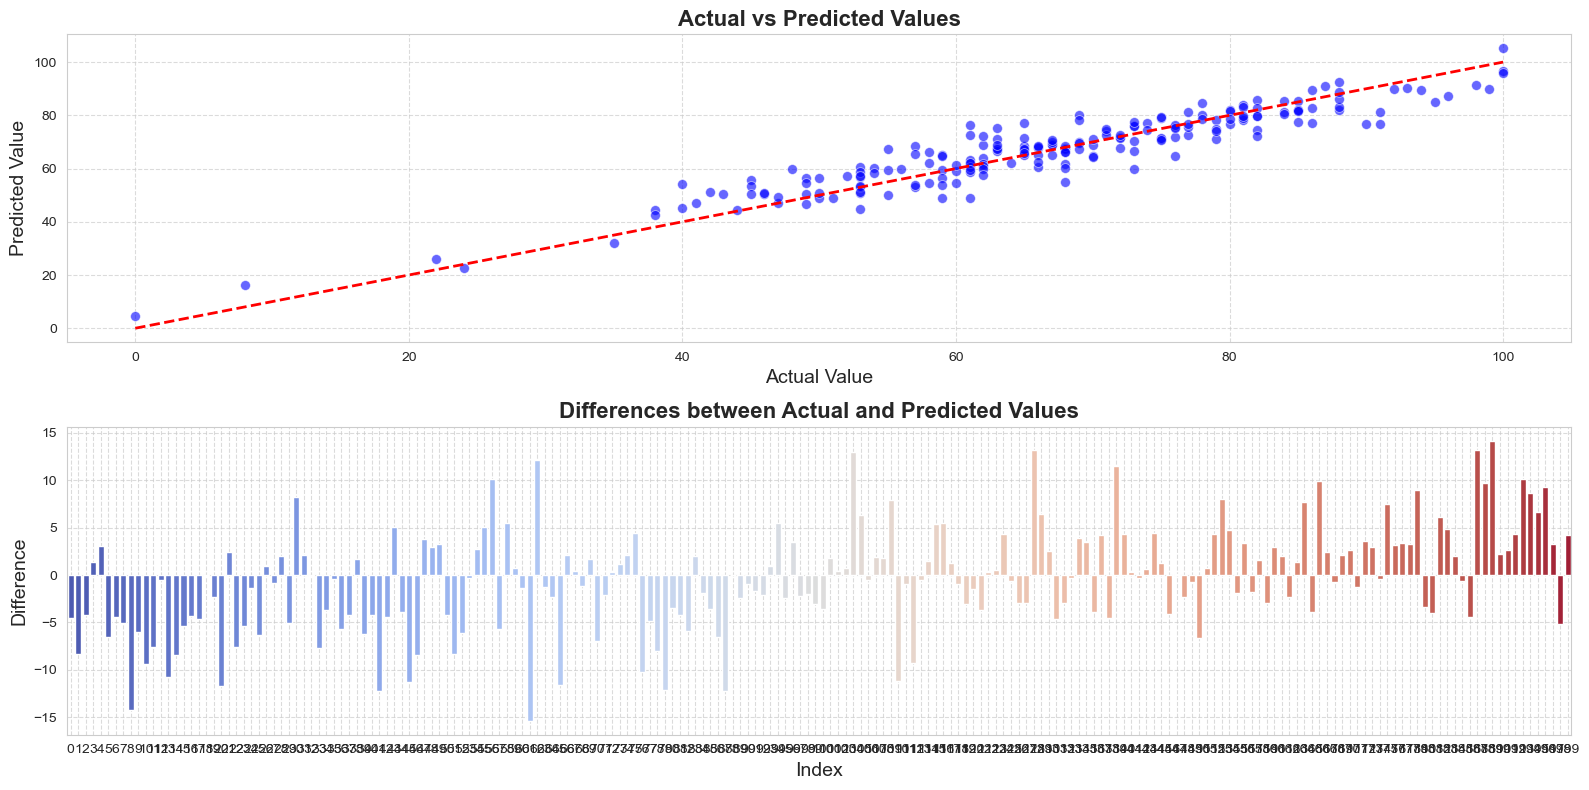

In [42]:
# Plotting the Actual vs Predicted Values with their Differences
plt.figure(figsize=(16, 8))

# Scatter plot for actual vs predicted values
plt.subplot(2, 1, 1)
sns.scatterplot(x='Actual Value', y='Predicted Value', data=pred_df_new, color='blue', s=50, alpha=0.6, edgecolor='w')
plt.plot([pred_df_new['Actual Value'].min(), pred_df_new['Actual Value'].max()],
         [pred_df_new['Actual Value'].min(), pred_df_new['Actual Value'].max()],
         color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values', fontsize=16, fontweight='bold')
plt.xlabel('Actual Value', fontsize=14)
plt.ylabel('Predicted Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Bar plot for differences
plt.subplot(2, 1, 2)
sns.barplot(x=pred_df_new.index, y='Difference', data=pred_df_new, palette='coolwarm')
plt.title('Differences between Actual and Predicted Values', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Difference', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()